In [1]:
import numpy as np
import scipy as sp 
from methods import *
import matplotlib.pyplot as plt

#### a)

c:\Users\magnu\OneDrive\Dokumenter\DTU\02689 Advanced Numerical Methods\gitstuff2\02689_Assignments\methods.py:74: RuntimeWarning: divide by zero encountered in divide
  J += np.diag(-1/2 * (alpha**2 - beta**2) *(1/ (h1 + 2)) *(1/ h1)) + np.diag(np.array(2 / (h1[:N] + 2) * np.sqrt((np.arange(1, N + 1) *
c:\Users\magnu\OneDrive\Dokumenter\DTU\02689 Advanced Numerical Methods\gitstuff2\02689_Assignments\methods.py:74: RuntimeWarning: invalid value encountered in multiply
  J += np.diag(-1/2 * (alpha**2 - beta**2) *(1/ (h1 + 2)) *(1/ h1)) + np.diag(np.array(2 / (h1[:N] + 2) * np.sqrt((np.arange(1, N + 1) *


[[ 0.5        -1.5         2.5        -3.5         4.5        -5.5
   6.5        -7.5       ]
 [ 0.5         1.5         2.5         3.5         4.5         5.5
   6.5         7.5       ]
 [ 0.          0.33333333  1.          0.14285714  0.          0.
   0.          0.        ]
 [ 0.          0.          0.2         1.          0.11111111  0.
   0.          0.        ]
 [ 0.          0.          0.          0.14285714  1.          0.09090909
   0.          0.        ]
 [ 0.          0.          0.          0.          0.11111111  1.
   0.07692308  0.        ]
 [ 0.          0.          0.          0.          0.          0.09090909
   1.          0.06666667]
 [ 0.          0.          0.          0.          0.          0.
   0.07692308  1.        ]]


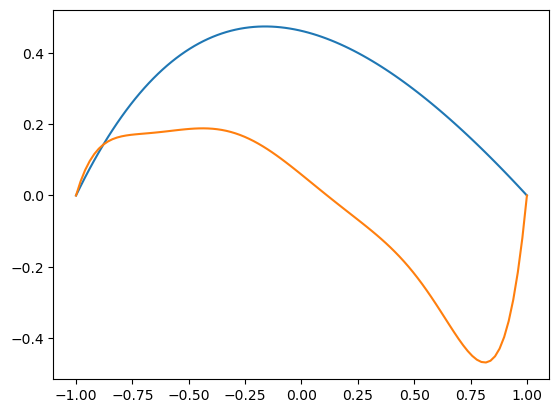

In [8]:
def ffun(x):
    return 1
ffun = np.vectorize(ffun)

def utrue(x,eps):
    return ( np.exp(-x/eps) + x - 1 - np.exp(-1/eps)*x )/( np.exp(-1/eps) - 1 )

def testtrue(x):
    return ( np.exp(2) + 1 - 2*np.exp(1-x) )/(np.exp(2) - 1) - x
testtrue = np.vectorize(testtrue)

m = 100
#X = np.arange(m)/m*2 - 1
X = np.linspace(-1,1,m)

testsol = LTM_2ord(X, 7, -1, -1, ffun)

plt.figure
plt.plot(X,testtrue(X))
plt.plot(X,testsol)
plt.show()